# Signal Data Exploration and Preprocessing

Author: Hriday Baghar

Purpose: Apply the preprocessing steps of the paper "Automatic classification with an autoencoder of seismic signals on a distributed acoustic sensing cable" on DAS data provided by ocean data lab

# 0. Setup

Import required packages

In [1]:
import h5py
import numpy as np
import scipy.signal as sp
import matplotlib.pyplot as plt
from datetime import datetime
from pyproj import Proj

# 1. Load data

### Reading HDF5 files and accessing metadata

HDF5 stands for "Hierarchical Data Format, version 5". HDF5 is a flexible alternative to conventional seismic data formats that permits us to store large volumes of binary data along with appropriate metadata. One principal advantage of the HDF5 format is that it permits efficient slicing&mdash;for instance, you can read the data for a single channel without having to load the entire file into memory. Another advantage is that HDF5 permits concurrent read/write operations, which is convenient for parallel computing applications. 

HDF5 files contain two types of object: groups and datasets. Groups put the "hierarchical" in HDF5, and act like folders, containing other groups or datasets. Datasets are exactly what they sound like&mdash;the actual data. All objects in an HDF5 file have attributes, which are the metadata associated with that object. We can access an object or its attributes with keys, in a similar manner to Python dictionaries. 

First, let's open the file and print its contents. 

In [2]:
# The path to your file
fpath = '../data/North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5'

# Open the file for reading
fp = h5py.File(fpath,'r')

# Print the keys for the top-level object in the file
print(fp.keys())

<KeysViewHDF5 ['Acquisition']>


Within the "Acquisition" group, there are two groups: "Custom" and "Raw\[0\]". 

The first group "Custom" has attributes with more detailed information about the status and settings of the interrogator at the time of acquisition, such as whether the GPS clock was synced, whether decimation was applied to the streaming data, and the (hard coded) value of fiber refractive index used to convert time into distance. There are no further subgroups within "Custom". You can list the available attributes here with `fp['Acquisition']['Custom'].attrs.keys()`. 

The second group "Raw\[0\]" is a container for three more groups: "Custom" (not the same as above), "RawDataTime", and "RawData". The first of these, "Custom" is generally empty. The second, "RawDataTime", is a dataset containing the UTC timestamp for each sample in the file in units of microseconds. The third, "RawData", is the actual data. 

First, let's look at the "RawDataTime" dataset. We can treat it similarly to a NumPy array and index directly from the dataset object. 

In [3]:
# Create a new variable for the "RawDataTime" h5py dataset so we don't have to type so much
rawDataTime = fp['Acquisition']['Raw[0]']['RawDataTime']

# Get the first entry in "RawDataTime"
print('The first value in \"RawDataTime\" is',rawDataTime[0],\
      'which is the timestamp of the first sample in microseconds.')

# Convert this UTC timestamp to something readable with Python's datetime library
print('This equates to the date and time',datetime.utcfromtimestamp(rawDataTime[0]*1e-6))

# We can load the full contents of "RawDataTime" into a NumPy array
rawDataTimeArr = rawDataTime[:]

# Print the length of the array
print('\nThere are',len(rawDataTimeArr),'values in \"RawDataTime\"')

# Print the beginning and ending time of the dataset
print('The first sample is at',datetime.utcfromtimestamp(rawDataTimeArr[0]*1e-6),\
      'and the last sample is at',datetime.utcfromtimestamp(rawDataTimeArr[-1]*1e-6))

The first value in "RawDataTime" is 1635992582025000 which is the timestamp of the first sample in microseconds.
This equates to the date and time 2021-11-04 02:23:02.025000

There are 12000 values in "RawDataTime"
The first sample is at 2021-11-04 02:23:02.025000 and the last sample is at 2021-11-04 02:24:02.020000


Given the sampling rate here is 200 Hz, we see, as expected, that there are 200 x 60 = 12000 samples spanning one minute, and that the UTC timestamps for each sample also span exactly one minute down to millisecond precision. 

Now that we understand how groups, datasets, and attributes work in HDF5, let's take a look at the actual DAS data. This is stored in the dataset object at `fp['Acquisition']['Raw[0]']['RawData']`. This is a 2D dataset (channel/distance vs. time), as evidenced by the string stored in the attribute `rawData.attrs['Dimensions']`. This order is determined by a recording software user switch allowing to store the data in trace-order or channel-order. Generally the first axis is distance, and the second axis is time, for fast time-domin processing, and is normally constant throughout the reocrding. It is good to check this attribute value when reading a file. 

We can read a single channel using the syntax `rawData[channel#,:]`, a block of channels as `rawData[firstChannel:lastChannel,:]`, a time slice as `rawData[:,firstSample:lastSample]`, etc. 

Sampling rate derived from timestamps: 200.0 Hz
Sampling rate derived from metadata: 200.0 Hz


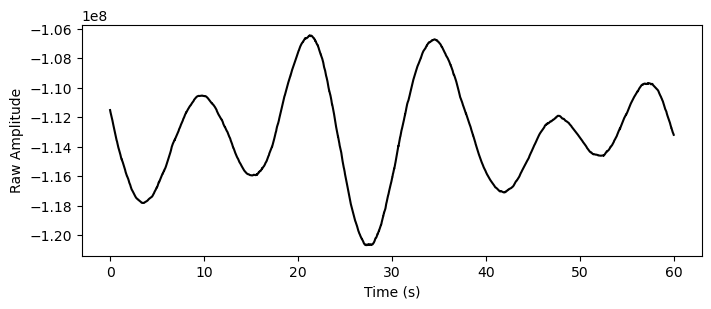

In [4]:
# Create a new variable for the "RawData" h5py dataset
rawData = fp['Acquisition']['Raw[0]']['RawData']

# Get the data for a single channel
trace = rawData[5000,:]

# In order to plot this trace, we need a time axis
# We can get the sample interval either from the time stamps or from the metadata
dt = (rawDataTime[1]-rawDataTime[0]) * 1e-6
fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
print('Sampling rate derived from timestamps:',1./dt,'Hz')
print('Sampling rate derived from metadata:',fs,'Hz')

# Now, plot it
time = np.arange(len(trace)) * dt
plt.figure(figsize=(8,3))
plt.plot(time,trace,'k')
plt.xlabel('Time (s)')
plt.ylabel('Raw Amplitude');

# 2. Signal Processing

In [5]:
# Assemble the metadata we will need
fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate'] # sampling rate in Hz
dx = fp['Acquisition'].attrs['SpatialSamplingInterval'] # channel spacing in m
nx = fp['Acquisition']['Raw[0]'].attrs['NumberOfLoci'] # number of channels
ns = fp['Acquisition']['Raw[0]']['RawDataTime'].attrs['Count'] # number of samples
L = fp['Acquisition'].attrs['GaugeLength'] # gauge length in m
n = fp['Acquisition']['Custom'].attrs['Fibre Refractive Index'] # refractive index
scale_factor = (2*np.pi)/2**16 * (1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L)

print('Sampling rate:',fs,'Hz')
print('Channel spacing:',dx,'m')
print('Number of channels:',nx)
print('Number of samples:',ns)
print('Gauge length:',L,'m')
print('Refractive index:',n)

# Create some useful arrays
t = np.arange(ns)/fs # time in s
x = np.arange(nx)*dx # distance in m
frq = np.fft.rfftfreq(ns,d=1./fs) # frequency in Hz

Sampling rate: 200.0 Hz
Channel spacing: 2.0419047 m
Number of channels: 32600
Number of samples: 12000
Gauge length: 51.04762 m
Refractive index: 1.4682


Steps taken in paper:

1. SNR improvement - 10 m gauge length was used whereby signals from the channel depth ±5 m were coherently averaged *(what is the right way to do this? Gauge length needs to be understood, or can we just arbitrarily group n channels together? is it a rolling average?)*
2. Segment merging - merged segements into 1 day traces, detrended, low-pass filtered and decimated to 50Hz sampling rate *(do we need all parts of this step? For now let us reduce sampling)*
3. Median subtraction - calculated the median at each time point across all traces and then subtracted the median of all traces from each trace
4. Band-pass filtering - band pass filter to frequency range of interest *(15-25Hz is one range, do we want to also try other ranges? Probably a good idea to parameterize this in a function)*
5. STA/LTA - 0.5s STA and 30s LTA, trigger 15 and de-trigger 10 *(find package to do this, document in NB)*
6. SNR filtering - ratio of the trace’s maximum amplitude to the root mean square of the trace, was calculated, and only traces with SNR ≥ 3.5 were retained for clustering analysis.

In [6]:
def downsample(fp,fs_new):
    """
    Downsample the data to fs_new.
    """
    fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    ds = int(fs/fs_new) # Number of samples to skip
    rawData = fp['Acquisition']['Raw[0]']['RawData']
    
    return rawData[:,0:rawData.shape[1]:ds], ds

def median_subtract(rawData):
    """
    Subtract median of each timepoint from all traces
    """
    return rawData - np.tile(np.median(rawData,axis=1),(rawData.shape[1],1)).T

def bandpass_filter(rawData, ds, low, high):
    """
    Apply a bandpass filter to the data.
    """

    fs = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate']
    nyq = fs/2/ds
    low = low/nyq
    high = high/nyq
    
    b, a = sp.butter(4, [low, high], 'bandpass')
    
    return sp.filtfilt(b, a, rawData, axis=1)


NOTE: Bandpass filter requires that the sampling frequency is 2x > than the upper cutoff frequency. Reason needs to be investgated. Given this, we might not be able to downsample the signal a lot, especially if we are trying to work with higher frequency ranges (in the 50s or perhaps 100s). Also, we might have to couple our code such that there are integrity checks. If we are downsampling our signal, it should not be possible to viloate the filter constraint - i.e. if we have fs=50 then bpf cannot have upper bound of 25.

In [7]:
# Fow now we downsample to 100 Hz which is 4x the upper bound for our filter.
downsampledData, ds = downsample(fp, 100)

In [8]:
downsampledData.shape, rawData.shape

((32600, 6000), (32600, 12000))

In [9]:
median_subtracted = median_subtract(downsampledData)

In [10]:
filtered = bandpass_filter(median_subtracted, ds, 15, 25)

In [11]:
# Calculate envelope
en = abs(sp.hilbert(filtered,axis=1))

## 3. Signal Visualization

In [12]:
fs0 = fp['Acquisition']['Raw[0]'].attrs['OutputDataRate'] # sampling rate in Hz
xmin = 0
xmax = 32600
xint = 1
tmin = int(20*fs0)
tmax = int(40*fs0)
tint = 1

nnx = filtered.shape[0]
nns = filtered.shape[1]

tr = filtered[xmin:xmax:xint,tmin:tmax:tint]

# Define new time and distance axes
time = (np.arange(nns)*tint + tmin)/fs
dist = (np.arange(nnx)*xint + xmin)*dx

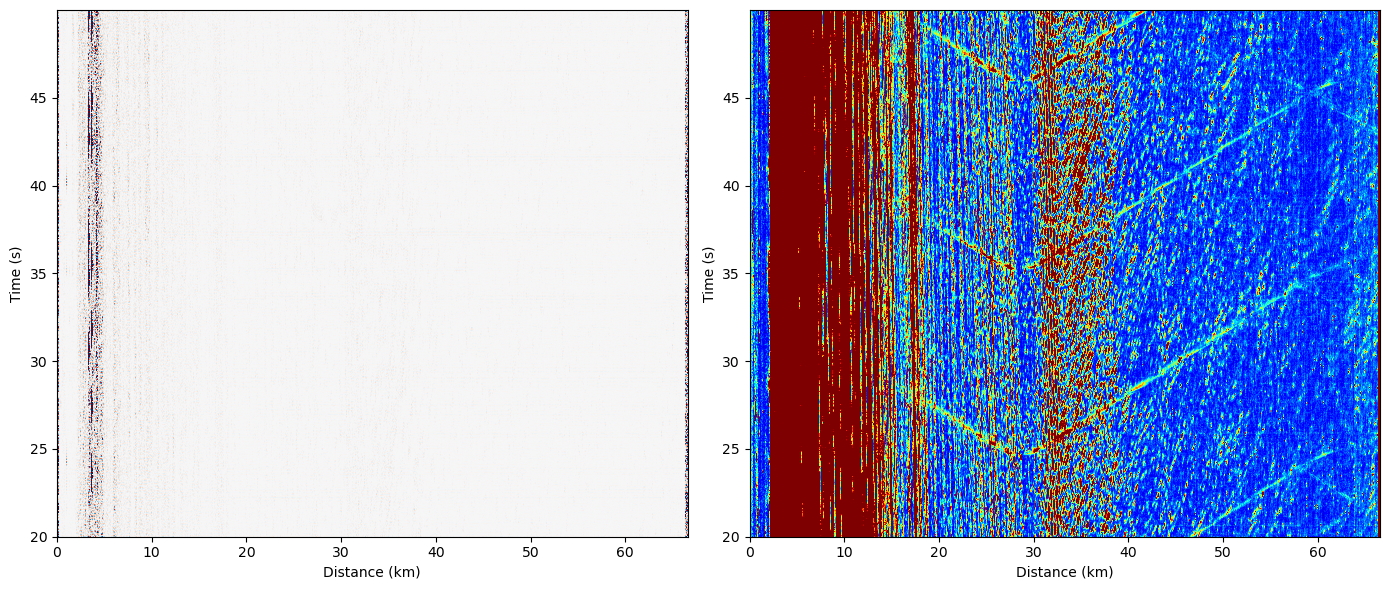

In [13]:
# Plot the filtered data in the time domain
fig,ax = plt.subplots(1,2,figsize=(14,6))
ax[0].imshow(tr.T,extent=[min(dist)*1e-3,max(dist)*1e-3,min(time),max(time)],aspect='auto',\
             origin='lower',cmap='RdBu',vmin=-1e3,vmax=1e3)
ax[0].set_xlabel('Distance (km)')
ax[0].set_ylabel('Time (s)')

# Plot the envelope of the filtered data
ax[1].imshow(en.T,extent=[min(dist)*1e-3,max(dist)*1e-3,min(time),max(time)],aspect='auto',\
             origin='lower',cmap='jet',vmin=0,vmax=1e3)
ax[1].set_xlabel('Distance (km)')
ax[1].set_ylabel('Time (s)')
plt.tight_layout()